In [1]:
import numpy as np


In [2]:
np.log(3.5)

1.252762968495368

In [60]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
from class_siir_mdl import SIIR
from class_state_vec import state_vector
from class_obs import obs_da
from class_da_sys import da_system
import copy
from copy import deepcopy
import random
import sys
import math
#import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import datetime
import pickle
import pmdarima as pm

#-----------------------------------------------------------------------
# Read the da system object
#-----------------------------------------------------------------------
name = 'x_analysis'
infile = name+'_init.pkl'
das = da_system()
das = das.load(infile)        
#random.seed(2)

#-----------------------------------------------------------------------
# Get the nature run trajectory
#-----------------------------------------------------------------------
sv = das.getStateVector()
x_nature = sv.getTrajectory()  
estimate_para = sv.getParaName()
country_name = sv.getCountry()
Condition = sv.getCondition()
date_2 = sv.getDate()
#-----------------------------------------------------------------------
# Initialize the ensemble
#-----------------------------------------------------------------------
if Condition ==2:
    with open('%s/Xa_history_%s.txt'%(country_name,date_2[0]), 'rb') as f: #change file name!!!!!!!!!!!!!!!!
        Xa_history_pre = pickle.load(f)
    with open('%s/Xs_history_%s.txt'%(country_name,date_2[0]), 'rb') as f: #change file name!!!!!!!!!!!!!!!!
        Xs_history_pre = pickle.load(f)
    with open('%s/Xp_history_%s.txt'%(country_name,date_2[0]), 'rb') as f: #change file name!!!!!!!!!!!!!!!!
        Xp_history_pre = pickle.load(f)
    with open('%s/Xf_history_%s.txt'%(country_name,date_2[0]), 'rb') as f: #change file name
        Xf_history_pre = pickle.load(f)

    #with open('para_compute_daily_210904.pkl', 'rb') as f: #change file name
    #    para_compute_daily_pre = pickle.load(f)

    Xa = Xa_history_pre[-1,:,:]
    #Xa = das.initEns(np.mean(Xa_history_pre[-1,:,:], axis = 1),mu=das.ens_bias_init,sigma=das.ens_sigma_init,edim=das.edim)
elif Condition == 1:
    xa = np.log(sv.getInitial())
    print(np.exp(xa))
    x0 = xa
    Xa = das.initEns(xa,mu=das.ens_bias_init,sigma=das.ens_sigma_init,edim=das.edim)

Xa= np.matrix(Xa)
Xa_original = np.exp(Xa[:,:])
print('Xa_original = ', Xa_original)
print('X0 = ')
print(Xa)

#-----------------------------------------------------------------------
# Get the S-I1-I2-R observations via the obs_da object
#-----------------------------------------------------------------------
obs = das.getObsData()
y_obs = obs.getVal()
y_pts = obs.getPos()
print('y_obs_0 = ')
print(y_obs[0,:])
print('y_pts_0 = ')
print(y_pts[0,:])

#-----------------------------------------------------------------------
# Initialize the timesteps
#-----------------------------------------------------------------------
acyc_step = das.acyc_step
dt = das.dt
maxit = das.maxit
xdim = das.xdim
ydim = das.ydim
edim = das.edim
date_series = sv.getTimeseries()

#-----------------------------------------------------------------------
# Compute some parameters using observations of H, RH and D
#-----------------------------------------------------------------------

para_compute = np.zeros((len(y_obs)-1,2))
#para_compute[0,:] = [0.98*(1/12) , 0.02*(1/10)]
for i in range(0,len(y_obs)-2):
    para_compute[i,0] = (np.exp(y_obs[i+1,1]) - np.exp(y_obs[i,1]))/np.exp(y_obs[i,0]) #gammaH
    para_compute[i,1] = (np.exp(y_obs[i+1,2]) - np.exp(y_obs[i,2]))/np.exp(y_obs[i,0]) #gammaD
para_compute[-1,:] = para_compute[-2,:]
para_compute_daily = copy.deepcopy(para_compute)

#average the parameter value
p = copy.deepcopy(para_compute)

def binomcoeffs(n): 
    return (np.poly1d([0.5, 0.5])**n).coeffs

radius  = 3
concoeef = binomcoeffs(2*radius)
para_compute[:,0] = ndimage.convolve(p[:,0],concoeef, mode='nearest')
para_compute[:,1] = ndimage.convolve(p[:,1],concoeef, mode='nearest')


if country_name == 'Japan': 
    #slope_para = [[0.4,0.3,0.4],[0.6,0.5,0.6]]
    slope_para = [[0,0,0],[0,0,0]]
else:
    slope_para = [[0.3,0.2,0.3],[0.4,0.3,0.4]] 
    #slope_para = [[0,0,0],[0,0,0]]
   
slope_para = np.matrix(slope_para)


N = sv.getPopulation()
epsilon = 1/1 #1/3
gamma1 = 0.17 * (1/9)
gamma2 = 0.22 * (1/7) #20210705 replace 1/9 by 1/7    0.22 * (1/7)
sigma =  0.83 * (1/2)
tauH = np.zeros(2)
tauH[0] = 0.78 * (1/8.3)
tauH[1] = 0.78  * (1/1) #0.78*(1/5.2)
gammaH = 0.97 * (1/14)
gammaD = 0.03 * (1/10)
beta_before = 0
#beta_before = 0.4*(np.mean(Xa[-1,:]) - np.mean(Xa_history_pre[-2,-1,:]))
method = das.getMethod() 

#-----------------------------------------------------------------------
# Conduct data assimilation process
#-----------------------------------------------------------------------
DA_count = 0

if Condition==1: #full outbreak
    Xa_history = np.zeros((date_series[-1]+1, xdim, edim))
    Xf_history = np.zeros((date_series[-1]+1, xdim, edim))
    Xp_history = np.zeros((date_series[-1]+1, xdim, edim))
    Xs_history = np.zeros((date_series[-1]+1, xdim, edim))
    Xa_history[0,:,:] = Xa
    Xf_history[0,:,:] = Xa
    Xp_history[0,:,:] = Xa
    Xs_history[0,:,:] = Xa
    slope_list = []
    time_interval = [0,date_series[-1]]
elif Condition ==2: #one day
    Xa_history = np.append(Xa_history_pre, np.zeros((59,das.xdim, das.edim)), axis = 0)
    Xs_history = np.append(Xs_history_pre, np.zeros((59,das.xdim, das.edim)), axis = 0)
    Xp_history = np.append(Xp_history_pre, np.zeros((59,das.xdim, das.edim)), axis = 0)
    Xf_history = np.append(Xf_history_pre, np.zeros((59,das.xdim, das.edim)), axis = 0)
    slope_list = np.mean(Xp_history_pre[-11:-1,-1,:],axis = 1) - np.mean(Xp_history_pre[-12:-2,-1,:], axis = 1)
    time_interval = [len(y_obs)-60,len(y_obs)-1] #[len(y_obs)-2,len(y_obs)-1]

#Ecorre_history = np.zeros((date_series[-1], ydim+1, edim))

arima_length = 10

window = 2
Xf = np.zeros_like(Xa) # #states * edim

for i in range(time_interval[0], time_interval[1]):       
  uncertainty = True
  hand_made_slope = False
  arima_slope = False

  t = np.arange(0,1.005, 0.01)
    
  yo = y_obs[i + 1, :]
  print('Y_number = ', np.exp(yo))
  
  xf_4d_box = np.zeros((edim, len(t), xdim))
  
  for k in range(edim):
    std_betas = 1
    
    if para_compute[i,0]<0 and para_compute[i,1]<0:
        para_compute[i,:] = 0
        smd = SIIR(N = N, epsilon = epsilon + np.random.normal(0,0.1*epsilon), 
                       gamma1 = gamma1 + np.random.normal(0,0.1*gamma1), 
                       gamma2 = gamma2 + np.random.normal(0,0.1*gamma2), 
                       sigma = sigma + np.random.normal(0,0.1*sigma), 
                       tauH = tauH[1] + np.random.normal(0,0.1*tauH[1]), 
                       gammaH = para_compute[i, 0] ,
                       gammaD = para_compute[i, 1], 
                       p = 0, beta_before = beta_before)
    elif  para_compute[i,0]<0:
        para_compute[i,0] = 0
        smd = SIIR(N = N, epsilon = epsilon + np.random.normal(0,0.1*epsilon), 
                       gamma1 = gamma1 + np.random.normal(0,0.1*gamma1), 
                       gamma2 = gamma2 + np.random.normal(0,0.1*gamma2), 
                       sigma = sigma + np.random.normal(0,0.1*sigma), 
                       tauH = tauH[1] + np.random.normal(0,0.1*tauH[1]), 
                       gammaH = para_compute[i, 0] ,
                       gammaD = para_compute[i, 1]+np.random.normal(0,0.1*para_compute[i, 1]), 
                       p = 0, beta_before = beta_before)
    elif para_compute[i,1]<0:
        para_compute[i,1] = 0
        smd = SIIR(N = N, epsilon = epsilon + np.random.normal(0,0.1*epsilon), 
                       gamma1 = gamma1 + np.random.normal(0,0.1*gamma1), 
                       gamma2 = gamma2 + np.random.normal(0,0.1*gamma2), 
                       sigma = sigma + np.random.normal(0,0.1*sigma), 
                       tauH = tauH[1] + np.random.normal(0,0.1*tauH[1]), 
                       gammaH = para_compute[i, 0] +np.random.normal(0,0.1*para_compute[i, 0]),
                       gammaD = para_compute[i, 1], 
                       p = 0, beta_before = beta_before)
    else:
        smd = SIIR(N = N, epsilon = epsilon + np.random.normal(0,0.1*epsilon), 
                           gamma1 = gamma1 + np.random.normal(0,0.1*gamma1), 
                           gamma2 = gamma2 + np.random.normal(0,0.1*gamma2), 
                           sigma = sigma + np.random.normal(0,0.1*sigma), 
                           tauH = tauH[1] + np.random.normal(0,0.1*tauH[1]), 
                           gammaH = para_compute[i, 0] + np.random.normal(0,0.1*para_compute[i, 0]),
                           gammaD = para_compute[i, 1] + np.random.normal(0,0.1*para_compute[i, 1]), 
                           p = 0, beta_before = beta_before)
    while (std_betas > 1e-6):
        xf_4d_k = smd.run(Xa[:,k].A1, t, t, estimate_para) 
        std_betas = np.std(xf_4d_k[:,-1])
       

    Xf[:,k] = (np.matrix(xf_4d_k[-1,:])).T

    
  slope_list = np.append(slope_list, np.mean(Xp_history[i,-1,:]) - np.mean(Xp_history[i-1,-1,:])) #  check!!!
  if Condition ==1:
      if arima_slope and i > 50:
          df = slope_list[-arima_length:]
          df = pd.DataFrame(df, columns = ['data'])
          result = adfuller(df.data)
          model_adj = pm.auto_arima(df.data, start_p=1, start_q=1,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=7, max_q=7, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
          fc_adj, confint_adj = model_adj.predict(n_periods=1, return_conf_int=True, alpha = 0.05)
          if fc_adj<0 and abs(abs(slope_list[-2])-abs(slope_list[-1]))>abs(abs(slope_list[-3])-abs(slope_list[-2])):
              if np.exp(np.mean(Xa_history[i,3,:]))> y_obs[i,0]:
                Xf[-1,:] = Xf[-1,:] + slope_para[0,0]*fc_adj
              else:
                Xf[-1,:] = Xf[-1,:] + 0*fc_adj

          elif fc_adj<0 and abs(abs(slope_list[-2])-abs(slope_list[-1]))<=abs(abs(slope_list[-3])-abs(slope_list[-2])):
              if np.exp(np.mean(Xa_history[i,3,:]))> y_obs[i,0]:
                Xf[-1,:] = Xf[-1,:] + slope_para[0,1]*fc_adj
              else:
                Xf[-1,:] = Xf[-1,:] + 0*fc_adj
          else:
              if np.exp(np.mean(Xa_history[i,3,:]))> y_obs[i,0]:
                Xf[-1,:] = Xf[-1,:] + 0*fc_adj
              else:
                Xf[-1,:] = Xf[-1,:] + slope_para[0,2]*fc_adj
  if Condition ==2:
      if arima_slope:
          df = slope_list[-arima_length:]
          df = pd.DataFrame(df, columns = ['data'])
          result = adfuller(df.data)
          model_adj = pm.auto_arima(df.data, start_p=1, start_q=1,
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=7, max_q=7, # maximum p and q
                        m=1,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
          fc_adj, confint_adj = model_adj.predict(n_periods=1, return_conf_int=True, alpha = 0.05)
          if fc_adj<0 and abs(abs(slope_list[-2])-abs(slope_list[-1]))>abs(abs(slope_list[-3])-abs(slope_list[-2])):
              if np.exp(np.mean(Xa_history[i,3,:]))> y_obs[i,0]:
                Xf[-1,:] = Xf[-1,:] + slope_para[0,0]*fc_adj
              else:
                Xf[-1,:] = Xf[-1,:] + 0*fc_adj

          elif fc_adj<0 and abs(abs(slope_list[-2])-abs(slope_list[-1]))<=abs(abs(slope_list[-3])-abs(slope_list[-2])):
              if np.exp(np.mean(Xa_history[i,3,:]))> y_obs[i,0]:
                Xf[-1,:] = Xf[-1,:] + slope_para[0,1]*fc_adj
              else:
                Xf[-1,:] = Xf[-1,:] + 0*fc_adj
          else:
              if np.exp(np.mean(Xa_history[i,3,:]))> y_obs[i,0]:
                Xf[-1,:] = Xf[-1,:] + 0*fc_adj
              else:
                Xf[-1,:] = Xf[-1,:] + slope_para[0,2]*fc_adj
  
  Xf_history[i + 1,:,:] = copy.copy(Xf)
  
  total_diff = list([1,1,1,1,1,1,1,1])
  while len([item for item in total_diff if item > 0])>0:
      #print('re-update')
      Xa, KH, Ecorre = das.compute_analysis(Xf,yo, i)   # (#state+#para) * (#esemble)  
      if np.std(Xa[6,:])>0.4:
            print('re-update')
            Xa[6,:] = 0.4/np.std(Xa[6,:]) * (Xa[6,:] - np.mean(Xa[6,:])) + np.zeros(edim) + np.mean(Xa[6,:])
      if np.std(Xa[7,:])>0.4:
            print('re-update')
            Xa[7,:] = 0.4/np.std(Xa[7,:]) * (Xa[7,:] - np.mean(Xa[7,:])) + np.zeros(edim) + np.mean(Xa[7,:])
      total_diff = (np.sum(np.exp(Xa[0:xdim-1,:]),axis = 0) - N).A1
      err_count = []
      good_count = []
      for a in range(das.edim):
        if total_diff[a]>0:
            Xf[:,a] = 0
            err_count.append(a)
        else:
            good_count.append(a)
      Xf[:, err_count] = np.mean(Xf[:,good_count],axis = 1)

  #Xa, KH, Ecorre = das.compute_analysis(Xf,yo,i)   # (#state+#para) * (#esemble)      
  if hand_made_slope:
      if i > 0 and (np.mean(Xa[-1,:])-np.mean(Xf[-1,:]))*(np.mean(Xa[-1,:]) - np.mean(Xa_history[i,-1,:]))>0:
          beta_before = (0.3)*(np.mean(Xa[-1,:]) - np.mean(Xa_history[i,-1,:]))
      else:
          #beta_before = 0.01*(np.mean(Xa[-1,:]) - np.mean(Xa_history[i,-1,:]))
          beta_before = 0.2*(np.mean(Xa[-1,:]) - np.mean(Xf[-1,:]))

  Xa_history[i + 1,:,:] = Xa
  xa = np.mean(Xa,axis=1)
  if N - sum(np.exp(xa[0:xdim-1])) < 0:
    sys.exit()
    
  #2022-03-10 sun qiwen
  p_diff = 0.02
  if np.mean(np.exp(Xa_history[i+1,3,:]))-np.exp(y_obs[i+1,0])> p_diff*(np.exp(y_obs[i+1,0])) and np.mean(np.exp(Xa_history[i,3,:]))-np.exp(y_obs[i,0])> p_diff*(np.exp(y_obs[i,0])):
        Xa_history[i+1,-1,:] = np.log(np.exp(Xa_history[i+1,-1,:]) - 0.1*np.exp(Xa_history[i+1,-1,:]))
  if np.exp(y_obs[i+1,0]) - np.mean(np.exp(Xa_history[i+1,3,:]))> p_diff*(np.exp(y_obs[i+1,0])) and np.exp(y_obs[i,0]) - np.mean(np.exp(Xa_history[i,3,:])) > p_diff*(np.exp(y_obs[i,0])):
        Xa_history[i+1,-1,:] = np.log(np.exp(Xa_history[i+1,-1,:]) + 0.1*np.exp(Xa_history[i+1,-1,:]))
  
  
        
  #Ecorre_history[i,:,:]= Ecorre

  xa = xa.T
  print('xa = ', xa)
  
  if i <= window:
    Xs_history[i+1,:,:] = Xa
    Xp_history[i+1,:,:] = Xa
  else:
    Xs_history[i+1,:,:] = Xa
    for u in range(i,i-window,-1):
        if u > len(Xa_history) -2:
            continue
        Paf = np.cov(Xa_history[u,:,:], Xf_history[u,:,:])[:das.xdim,das.xdim:]
        Pff = np.cov(Xf_history[u,:,:])
        K = Paf.dot(np.linalg.inv(Pff))
        Xs_history[u,:,:] = Xa_history[u,:,:] + K.dot(Xs_history[u+1,:,:] - Xf_history[u,:,:])
    p=1
    for q in range(i-window+1,i+1):
        yo_inner = y_obs[q + 1, :]
        print('Inner_Y_number = ', np.exp(yo_inner))
        for k in range(edim):
            std_betas = 1

            if para_compute[q,0]<0 and para_compute[q,1]<0:
                para_compute[q,:] = 0
                smd = SIIR(N = N, epsilon = epsilon + np.random.normal(0,0.1*epsilon), 
                               gamma1 = gamma1 + np.random.normal(0,0.1*gamma1), 
                               gamma2 = gamma2 + np.random.normal(0,0.1*gamma2), 
                               sigma = sigma + np.random.normal(0,0.1*sigma), 
                               tauH = tauH[1] + np.random.normal(0,0.1*tauH[1]), 
                               gammaH = para_compute[q, 0] ,
                               gammaD = para_compute[q, 1], 
                               p = 0, beta_before = beta_before)
            elif  para_compute[q,0]<0:
                para_compute[q,0] = 0
                smd = SIIR(N = N, epsilon = epsilon + np.random.normal(0,0.1*epsilon), 
                               gamma1 = gamma1 + np.random.normal(0,0.1*gamma1), 
                               gamma2 = gamma2 + np.random.normal(0,0.1*gamma2), 
                               sigma = sigma + np.random.normal(0,0.1*sigma), 
                               tauH = tauH[1] + np.random.normal(0,0.1*tauH[1]), 
                               gammaH = para_compute[q, 0] ,
                               gammaD = para_compute[q, 1]+np.random.normal(0,0.1*para_compute[q, 1]), 
                               p = 0, beta_before = beta_before)
            elif para_compute[q,1]<0:
                para_compute[q,1] = 0
                smd = SIIR(N = N, epsilon = epsilon + np.random.normal(0,0.1*epsilon), 
                               gamma1 = gamma1 + np.random.normal(0,0.1*gamma1), 
                               gamma2 = gamma2 + np.random.normal(0,0.1*gamma2), 
                               sigma = sigma + np.random.normal(0,0.1*sigma), 
                               tauH = tauH[1] + np.random.normal(0,0.1*tauH[1]), 
                               gammaH = para_compute[q, 0] +np.random.normal(0,0.1*para_compute[q, 0]),
                               gammaD = para_compute[q, 1], 
                               p = 0, beta_before = beta_before)
            else:
                smd = SIIR(N = N, epsilon = epsilon + np.random.normal(0,0.1*epsilon), 
                                   gamma1 = gamma1 + np.random.normal(0,0.1*gamma1), 
                                   gamma2 = gamma2 + np.random.normal(0,0.1*gamma2), 
                                   sigma = sigma + np.random.normal(0,0.1*sigma), 
                                   tauH = tauH[1] + np.random.normal(0,0.1*tauH[1]), 
                                   gammaH = para_compute[q, 0] + np.random.normal(0,0.1*para_compute[q, 0]),
                                   gammaD = para_compute[q, 1] + np.random.normal(0,0.1*para_compute[q, 1]), 
                                   p = 0, beta_before = beta_before)
                
            while (std_betas > 1e-6):
                xf_4d_k = smd.run(Xs_history[q,:,k], t, t, estimate_para) 
                std_betas = np.std(xf_4d_k[:,-1])

            Xf[:,k] = (np.matrix(xf_4d_k[-1,:])).T   # check!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        if Condition == 1:
            if arima_slope and i > 50:
              if p>0:
                  df = slope_list[-arima_lengthp-p:-p]
              else:
                  df = slope_list[-arima_lengthp-p:]
              df = pd.DataFrame(df, columns = ['data'])
              result = adfuller(df.data)
              model_adj = pm.auto_arima(df.data, start_p=1, start_q=1,
                            test='adf',       # use adftest to find optimal 'd'
                            max_p=7, max_q=7, # maximum p and q
                            m=1,              # frequency of series
                            d=None,           # let model determine 'd'
                            seasonal=False,   # No Seasonality
                            start_P=0, 
                            D=0, 
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
              fc_adj, confint_adj = model_adj.predict(n_periods=1, return_conf_int=True, alpha = 0.05)
              if fc_adj<0 and abs(abs(slope_list[-2])-abs(slope_list[-1]))>abs(abs(slope_list[-3])-abs(slope_list[-2])):
                  if np.exp(np.mean(Xp_history[q,3,:]))> y_obs[q,0]:
                    Xf[-1,:] = Xf[-1,:] + slope_para[1,0]*fc_adj
                  else:
                    Xf[-1,:] = Xf[-1,:] + 0*fc_adj
              elif fc_adj<0 and abs(abs(slope_list[-2])-abs(slope_list[-1]))<=abs(abs(slope_list[-3])-abs(slope_list[-2])):
                  if np.exp(np.mean(Xp_history[q,3,:]))> y_obs[q,0]:
                    Xf[-1,:] = Xf[-1,:] + slope_para[1,1]*fc_adj
                  else:
                    Xf[-1,:] = Xf[-1,:] + 0*fc_adj
              else:
                  if np.exp(np.mean(Xp_history[q,3,:]))> y_obs[q,0]:
                    Xf[-1,:] = Xf[-1,:] + 0*fc_adj
                  else:
                    Xf[-1,:] = Xf[-1,:] + slope_para[1,2]*fc_adj
        if Condition ==2:
            if arima_slope:
              if p>0:
                  df = slope_list[-arima_length-p:-p]
              else:
                  df = slope_list[-arima_length-p:]
              df = pd.DataFrame(df, columns = ['data'])
              result = adfuller(df.data)
              model_adj = pm.auto_arima(df.data, start_p=1, start_q=1,
                            test='adf',       # use adftest to find optimal 'd'
                            max_p=7, max_q=7, # maximum p and q
                            m=1,              # frequency of series
                            d=None,           # let model determine 'd'
                            seasonal=False,   # No Seasonality
                            start_P=0, 
                            D=0, 
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
              fc_adj, confint_adj = model_adj.predict(n_periods=1, return_conf_int=True, alpha = 0.05)
              if fc_adj<0 and abs(abs(slope_list[-2])-abs(slope_list[-1]))>abs(abs(slope_list[-3])-abs(slope_list[-2])):
                  if np.exp(np.mean(Xp_history[q,3,:]))> y_obs[q,0]:
                    Xf[-1,:] = Xf[-1,:] + slope_para[1,0]*fc_adj
                  else:
                    Xf[-1,:] = Xf[-1,:] + 0*fc_adj
              elif fc_adj<0 and abs(abs(slope_list[-2])-abs(slope_list[-1]))<=abs(abs(slope_list[-3])-abs(slope_list[-2])):
                  if np.exp(np.mean(Xp_history[q,3,:]))> y_obs[q,0]:
                    Xf[-1,:] = Xf[-1,:] + slope_para[1,1]*fc_adj
                  else:
                    Xf[-1,:] = Xf[-1,:] + 0*fc_adj
              else:
                  if np.exp(np.mean(Xp_history[q,3,:]))> y_obs[q,0]:
                    Xf[-1,:] = Xf[-1,:] + 0*fc_adj
                  else:
                    Xf[-1,:] = Xf[-1,:] + slope_para[1,2]*fc_adj
        p = p-1
        total_diff = list([1,1,1,1,1,1,1,1])
        while len([item for item in total_diff if item > 0])>0:
          #print('re-update')
          Xa_inner, KH, Ecorre = das.compute_analysis(Xf,yo_inner, i)   # (#state+#para) * (#esemble)  
          if np.std(Xa[6,:])>0.4:
                #print('re-update')
                Xa_inner[6,:] = 0.4/np.std(Xa_inner[6,:]) * (Xa_inner[6,:] - np.mean(Xa_inner[6,:])) + np.zeros(edim) + np.mean(Xa_inner[6,:])
          if np.std(Xa[7,:])>0.4:
                #print('re-update')
                Xa_inner[7,:] = 0.4/np.std(Xa_inner[7,:]) * (Xa_inner[7,:] - np.mean(Xa_inner[7,:])) + np.zeros(edim) + np.mean(Xa_inner[7,:])
          total_diff = (np.sum(np.exp(Xa_inner[0:xdim-1,:]),axis = 0) - N).A1
          err_count = []
          good_count = []
          for a in range(das.edim):
            if total_diff[a]>0:
                Xf[:,a] = 0
                err_count.append(a)
            else:
                good_count.append(a)
          Xf[:, err_count] = np.mean(Xf[:,good_count],axis = 1)
        Xp_history[q + 1,:,:] = Xa_inner
        xa = np.mean(Xa_inner,axis=1)
        if N - sum(np.exp(xa[0:xdim-1])) < 0:
            sys.exit()
        

        
        
    
    
    
    
  DA_count = DA_count + 1
  print(DA_count)



# In[2]:



with open('%s/Xa_history_%s.txt'%(country_name,date_2[1]), 'wb') as f:
    pickle.dump(Xa_history, f)
with open('%s/Xs_history_%s.txt'%(country_name,date_2[1]), 'wb') as f:
    pickle.dump(Xs_history, f)
with open('%s/Xp_history_%s.txt'%(country_name,date_2[1]), 'wb') as f:
    pickle.dump(Xp_history, f)
with open('%s/Xf_history_%s.txt'%(country_name,date_2[1]), 'wb') as f:
    pickle.dump(Xf_history, f)


# In[3]:


#compute Rt ensemble Xp_history
ratio = 0.58
Bs = np.exp(Xp_history[:,-1,:]) #analysis ensemble value of beta_s in the last day, original scale
Ba = ratio*Bs  #analysis ensemble value of beta_a in the last day, original scale
m_bs = np.mean(Xp_history[:,-1,:], axis = 1) # mean of analysis ensemble of beta_s in log scale
std_m_bs = np.std(Xp_history[:,-1,:], axis = 1) # standard deviation of analysis ensemble of beta_s in log scale

epsilon = 1/3 
gamma2 = 0.22 * (1/7)
tauH[1] = 0.78 * (1/5.2)

RT1 = (Ba[0:666] / (sigma + gamma1))  + Bs[0:666] * sigma/((sigma+gamma1)*(gamma2+tauH[1])) #latest several days analysis ensemble of Rt
RT_mean1 = ratio*(np.exp(m_bs[0:666]) / (sigma + gamma1))  + np.exp(m_bs[0:666]) * sigma/((sigma+gamma1)*(gamma2+tauH[1])) #latest several days analysis ensemble mean of Rt

#compute Rt confidence interval Xs_history
RT_conf = np.zeros((5,len(Xp_history[:,:,:])))
RT_conf[0,0:666]= (ratio*np.exp(m_bs[0:666]-std_m_bs[0:666]) / (sigma + gamma1))  + np.exp(m_bs[0:666]-std_m_bs[0:666])* sigma/((sigma+gamma1)*(gamma2+tauH[1]))

RT_conf[1,0:666] = (ratio*np.exp(m_bs[0:666]+std_m_bs[0:666]) / (sigma + gamma1))  + np.exp(m_bs[0:666]+std_m_bs[0:666])* sigma/((sigma+gamma1)*(gamma2+tauH[1]))

RT_conf[2,0:666] = (ratio*np.exp(m_bs[0:666]-2*std_m_bs[0:666]) / (sigma + gamma1))  + np.exp(m_bs[0:666]-2*std_m_bs[0:666]) * sigma/((sigma+gamma1)*(gamma2+tauH[1]))
RT_conf[3,0:666] = (ratio*np.exp(m_bs[0:666]+2*std_m_bs[0:666])/ (sigma + gamma1))  + np.exp(m_bs[0:666]+2*std_m_bs[0:666]) * sigma/((sigma+gamma1)*(gamma2+tauH[1]))

RT_conf[4,0:666] = RT_mean1

epsilon = 1/1 #1/3
gamma2 = 0.22 * (1/7)
tauH[1] = 0.78 * (1/1)
RT2 = (Ba[666:] / (sigma + gamma1))  + Bs[666:] * sigma/((sigma+gamma1)*(gamma2+tauH[1])) #latest several days analysis ensemble of Rt
RT_mean2 = ratio*(np.exp(m_bs[666:]) / (sigma + gamma1))  + np.exp(m_bs[666:]) * sigma/((sigma+gamma1)*(gamma2+tauH[1])) #latest several days analysis ensemble mean of Rt

RT_conf[0,666:]= (ratio*np.exp(m_bs[666:]-std_m_bs[666:]) / (sigma + gamma1))  + np.exp(m_bs[666:]-std_m_bs[666:])* sigma/((sigma+gamma1)*(gamma2+tauH[1]))

RT_conf[1,666:] = (ratio*np.exp(m_bs[666:]+std_m_bs[666:]) / (sigma + gamma1))  + np.exp(m_bs[666:]+std_m_bs[666:])* sigma/((sigma+gamma1)*(gamma2+tauH[1]))

RT_conf[2,666:] = (ratio*np.exp(m_bs[666:]-2*std_m_bs[666:]) / (sigma + gamma1))  + np.exp(m_bs[666:]-2*std_m_bs[666:]) * sigma/((sigma+gamma1)*(gamma2+tauH[1]))
RT_conf[3,666:] = (ratio*np.exp(m_bs[666:]+2*std_m_bs[666:])/ (sigma + gamma1))  + np.exp(m_bs[666:]+2*std_m_bs[666:]) * sigma/((sigma+gamma1)*(gamma2+tauH[1]))

RT_conf[4,666:] = RT_mean2


rf_conf = RT_conf


# In[4]:


df = pd.DataFrame(rf_conf)
df.to_csv('%s/rt_conf_%s.csv'%(country_name,date_2[1]), header = None, index = False)


# In[5]:


#full simu for h and d Xs_history
pre_len = len(Xp_history[0:,:,:]) #number of days of simulation history
h_simu_full = np.zeros((5,pre_len))
d_simu_full = np.zeros((5,pre_len))
#3 is for state H
h_simu_full[0] = np.exp(np.mean(Xp_history[:,3,:], axis = 1)-np.std(Xp_history[:,3,:], axis = 1)) #68CI
h_simu_full[1] = np.exp(np.mean(Xp_history[:,3,:], axis = 1)+np.std(Xp_history[:,3,:], axis = 1)) #68CI
h_simu_full[2] = np.exp(np.mean(Xp_history[:,3,:], axis = 1)-2*np.std(Xp_history[:,3,:], axis = 1)) #95CI
h_simu_full[3] = np.exp(np.mean(Xp_history[:,3,:], axis = 1)+2*np.std(Xp_history[:,3,:], axis = 1)) #95CI
h_simu_full[4] = np.exp(np.mean(Xp_history[:,3,:], axis = 1)) #mean

#5 is for state d
d_simu_full[0] = np.exp(np.mean(Xp_history[:,5,:], axis = 1)-np.std(Xp_history[:,5,:], axis = 1)) #68CI
d_simu_full[1] = np.exp(np.mean(Xp_history[:,5,:], axis = 1)+np.std(Xp_history[:,5,:], axis = 1)) #68CI
d_simu_full[2] = np.exp(np.mean(Xp_history[:,5,:], axis = 1)-2*np.std(Xp_history[:,5,:], axis = 1)) #95CI
d_simu_full[3] = np.exp(np.mean(Xp_history[:,5,:], axis = 1)+2*np.std(Xp_history[:,5,:], axis = 1)) #95CI
d_simu_full[4] = np.exp(np.mean(Xp_history[:,5,:], axis = 1)) #mean


# In[6]:


increase = 0 #7 for B here we decide the scenario  #2021-08-08 Rt started to decrease
decrease = 65-increase
increase_slope = (rf_conf[4,-1]- rf_conf[4,-3])/2 #compute by the most recent analysis values of Rt, I took 3 days.
print('increase_slope=',increase_slope)
print(rf_conf[4,-6:])

rt_cont = np.zeros((4,increase+decrease+1,das.edim)) #(#slope, #future Rt + 1, #ensembles)
rt_cont[:,0,:] =  RT2[-1,:] #fill the day0 by the analysis values
rt_cont[-1,:,:] = RT2[-1,:]
for i in range(1,increase+1):
    rt_cont[0:3,i,:] =rt_cont[0:3,i-1,:] + increase_slope

#slopes = [-0.056251528, -0.014658377, -0.008511147] #1st state emergency , 2nd , 3rd #maybe change if one has better definition??
#slopes = [-0.021154715,-0.016355659, -0.017047247] #enks
if country_name == 'Tokyo':
    slopes = [-0.103549469,-0.013696764, -0.010316027] #tokyo
if country_name== 'Japan':
    slopes = [-0.04380301,-0.013351753,-0.007690019] #Japan

for i in range(increase+1,increase+decrease+1):
    for j in range(3):
        rt_cont[j,i,:] =rt_cont[j,i-1,:] + slopes[j]

#replace the negative number by a very small positive number
for ss in range(3):
    for i in range(increase+decrease+1):
        for j in range(das.edim):
            if rt_cont[ss,i,j]<0:
                #print(ss,i)
                rt_cont[ss,i,j] = 1e-4


# In[7]:


rt_cont_conf = np.zeros((4, 5, increase+decrease))
r_cont_mean = np.mean(rt_cont[:,1:,:], axis = 2)
r_cont_std = np.std(rt_cont[:,1:,:], axis = 2)

rt_cont_conf[:,-1,:] = r_cont_mean
rt_cont_conf[:,0,:] = r_cont_mean - r_cont_std
rt_cont_conf[:,1,:] = r_cont_mean + r_cont_std
rt_cont_conf[:,2,:] = r_cont_mean - 2*r_cont_std
rt_cont_conf[:,3,:] = r_cont_mean + 2*r_cont_std


rt_cont_conf = np.round(rt_cont_conf, decimals = 3)


# In[8]:


rt_cont_conf_reshape = rt_cont_conf.reshape(20,len(rt_cont_conf[0,0,:]))
df = pd.DataFrame(rt_cont_conf_reshape)
df.to_csv('%s/rt_cont_conf_reshape_%s.csv'%(country_name,date_2[1]), header = None, index = False)


# In[9]:


pred_new = np.zeros((4,das.edim,das.xdim,increase+decrease+1)) #(slope, ensembles, states, fcst lenth)
Bs_new = np.zeros((4,increase+decrease+1,das.edim)) #the future beta_s, computed by using future Rt

for i in range(4):
    #pred_new[i,:,:,0] = Xa_history[-1,:,:].T #day0 is the last day analysis result, be careful: they are log transformed value
    pred_new[i,:,:,0] = Xp_history[-1,:,:].T
    
for s in range(4):
    Bs_new[s,:,:] = (rt_cont[s,:,:]*(sigma+gamma1)*(gamma2+tauH[1]))/(ratio*(gamma2+tauH[1])+sigma) #origial scale, not log
    
t = np.arange(0,1.005, 0.01)
for s in range(4):
    for q in range(increase+decrease):
        for k in range(das.edim):
            # each daily forecast, we add some uncertainties to parameters
            smd = SIIR(N = N, epsilon = epsilon + np.random.normal(0,0.1*epsilon), 
                   gamma1 = gamma1 + np.random.normal(0,0.1*gamma1), 
                   gamma2 = gamma2 + np.random.normal(0,0.1*gamma2), 
                   sigma = sigma + np.random.normal(0,0.1*sigma), 
                   tauH = tauH[1] + np.random.normal(0,0.1*tauH[1]), 
                   gammaH = para_compute[-1, 0] + np.random.normal(0,0.1*para_compute[-1, 0]),
                   gammaD = para_compute[-1, 1] + np.random.normal(0,0.1*para_compute[-1, 1]), 
                   p = 0, beta_before = beta_before)
            xf_4d_k = smd.run(pred_new[s,k,:,q], t, t, estimate_para) #integration 1 day
            pred_new[s,k,:,q+1] = (np.matrix(xf_4d_k[-1,:])) #store the initial value for next day
            pred_new[s,k,-1,q+1] = np.log(Bs_new[s,q+1,k]) #replace the beta_s by pre-designed betas (don't forget to take log)


# In[10]:


h_pred = np.zeros((4,5,increase+decrease)) #(slope, CI and mean, predict length)
d_pred = np.zeros((4,5,increase+decrease))
for ss in range(4):
    h_pred[ss,4,:] = np.exp(np.mean(pred_new[ss,:,3,1:],axis = 0)) #start from 1 are forecast
    h_pred[ss,0,:] = np.exp(np.mean(pred_new[ss,:,3,1:],axis = 0)-np.std(pred_new[ss,:,3,1:],axis = 0))
    h_pred[ss,1,:] = np.exp(np.mean(pred_new[ss,:,3,1:],axis = 0)+np.std(pred_new[ss,:,3,1:],axis = 0))
    h_pred[ss,2,:] = np.exp(np.mean(pred_new[ss,:,3,1:],axis = 0)-2*np.std(pred_new[ss,:,3,1:],axis = 0))
    h_pred[ss,3,:] = np.exp(np.mean(pred_new[ss,:,3,1:],axis = 0)+2*np.std(pred_new[ss,:,3,1:],axis = 0))
    
for ss in range(4):
    d_pred[ss,4,:] = np.exp(np.mean(pred_new[ss,:,5,1:],axis = 0))
    d_pred[ss,0,:] = np.exp(np.mean(pred_new[ss,:,5,1:],axis = 0)-np.std(pred_new[ss,:,5,1:],axis = 0))
    d_pred[ss,1,:] = np.exp(np.mean(pred_new[ss,:,5,1:],axis = 0)+np.std(pred_new[ss,:,5,1:],axis = 0))
    d_pred[ss,2,:] = np.exp(np.mean(pred_new[ss,:,5,1:],axis = 0)-2*np.std(pred_new[ss,:,5,1:],axis = 0))
    d_pred[ss,3,:] = np.exp(np.mean(pred_new[ss,:,5,1:],axis = 0)+2*np.std(pred_new[ss,:,5,1:],axis = 0))


# In[11]:


#put the simulation histroy and prediction together
h_simu_pred = np.zeros((4,5,pre_len+decrease+increase)) #(slope, CI+MEAN, simu_history + forecast length)
d_simu_pred = np.zeros((4,5,pre_len+decrease+increase))
for i in range(4):
   h_simu_pred[i,:,:] = np.hstack((h_simu_full, h_pred[i,:,:]))
   d_simu_pred[i,:,:] = np.hstack((d_simu_full, d_pred[i,:,:]))

h_simu_pred = np.round(h_simu_pred)
d_simu_pred = np.round(d_simu_pred)


# In[12]:


h_simu_pred_reshape = h_simu_pred.reshape(20,len(h_simu_pred[0,0,:]))
d_simu_pred_reshape = d_simu_pred.reshape(20,len(d_simu_pred[0,0,:]))
df = pd.DataFrame(h_simu_pred_reshape)
df.to_csv('%s/h_simu_pred_%s_reshape.csv'%(country_name,date_2[1]), header = None, index = False)
df = pd.DataFrame(d_simu_pred_reshape)
df.to_csv('%s/d_simu_pred_%s_reshape.csv'%(country_name,date_2[1]), header = None, index = False)



Xa_original =  [[1.40654613e+02 6.49411214e+01 3.93370588e+02 4.70015301e+02
  2.91012148e+02 1.81469853e+02 3.44971929e+02 3.26509080e+02
  5.72157467e+02 4.60004265e+02 2.85525147e+02 2.56162681e+02
  4.12197927e+02 1.94787803e+02 8.49903065e+02]
 [1.08968983e+02 5.22051007e+01 2.51876772e+02 3.25750779e+02
  2.08813973e+02 1.18047178e+02 2.45012010e+02 2.54272452e+02
  3.85791575e+02 2.88156188e+02 2.00089216e+02 1.94154566e+02
  2.88669930e+02 1.44239525e+02 5.01358590e+02]
 [2.11878650e+02 1.20612460e+02 4.63451852e+02 5.16323164e+02
  3.78358593e+02 2.36179767e+02 4.23937122e+02 4.50160901e+02
  6.13961625e+02 4.97733866e+02 3.71945276e+02 3.22057417e+02
  4.30021203e+02 2.61296068e+02 7.36072337e+02]
 [5.58264712e+02 4.00911488e+02 5.88749714e+02 4.86748654e+02
  4.82434014e+02 4.06085814e+02 5.12007560e+02 4.89605963e+02
  5.24968351e+02 5.12539889e+02 4.62565718e+02 4.66408770e+02
  4.22520891e+02 5.04811381e+02 7.44200203e+02]
 [3.86069506e+05 3.70447030e+05 3.98994433e+05 3.

re-update
re-update
xa =  [[ 9.07359047  9.68201739  8.86930847 10.07495925 12.80450633  7.99385682
  10.02087609 11.42750225 -0.45331881]]
Inner_Y_number =  [ 23500. 380764.   3179.]
Inner_Y_number =  [ 27646. 381799.   3179.]
18
Y_number =  [ 33221. 383588.   3181.]
re-update
re-update
xa =  [[ 9.33209275  9.87085715  9.13779301 10.34981113 12.81431449  8.00468277
  10.04542884 11.41923257 -0.43169968]]
Inner_Y_number =  [ 27646. 381799.   3179.]
Inner_Y_number =  [ 33221. 383588.   3181.]
19
Y_number =  [ 40257. 385186.   3181.]
re-update
re-update
xa =  [[ 9.51023948 10.06722299  9.29377054 10.55553465 12.8261355   8.0137421
  10.068758   11.41880229 -0.42427101]]
Inner_Y_number =  [ 33221. 383588.   3181.]
Inner_Y_number =  [ 40257. 385186.   3181.]
20
Y_number =  [ 47971. 387167.   3181.]
re-update
re-update
xa =  [[ 9.69277951 10.22132664  9.4267924  10.74317482 12.82788672  8.0309187
  10.09578046 11.41670104 -0.41823979]]
Inner_Y_number =  [ 40257. 385186.   3181.]
Inner_Y_num

49
Y_number =  [175100. 710873.   3431.]
re-update
xa =  [[10.24264381 11.02189111 10.33049178 12.20033456 13.47194277  8.12377172
  10.49244425 11.24953729 -0.74537455]]
Inner_Y_number =  [179404. 693080.   3404.]
Inner_Y_number =  [175100. 710873.   3431.]
50
Y_number =  [173402. 725489.   3448.]
re-update
xa =  [[10.20780395 10.98329601 10.28193063 12.20711973 13.49616096  8.13058524
  10.48782334 11.23933503 -0.75361061]]
Inner_Y_number =  [175100. 710873.   3431.]
Inner_Y_number =  [173402. 725489.   3448.]
51
Y_number =  [168559. 739107.   3478.]
re-update
xa =  [[10.15580081 10.92262518 10.22337126 12.1947068  13.49858369  8.14595467
  10.46375351 11.22032976 -0.76384227]]
Inner_Y_number =  [173402. 725489.   3448.]
Inner_Y_number =  [168559. 739107.   3478.]
52
Y_number =  [171588. 747496.   3503.]
re-update
xa =  [[10.08694134 10.88006289 10.19466665 12.1917964  13.51233094  8.15401136
  10.44816602 11.19437783 -0.77164409]]
Inner_Y_number =  [168559. 739107.   3478.]
Inner_Y_

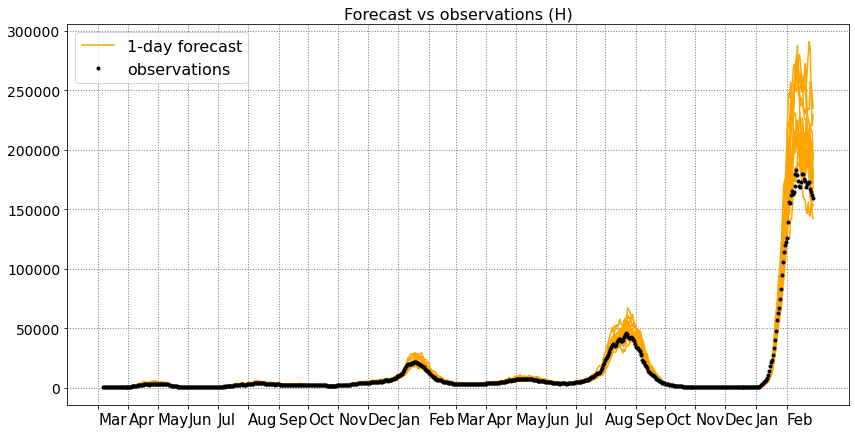

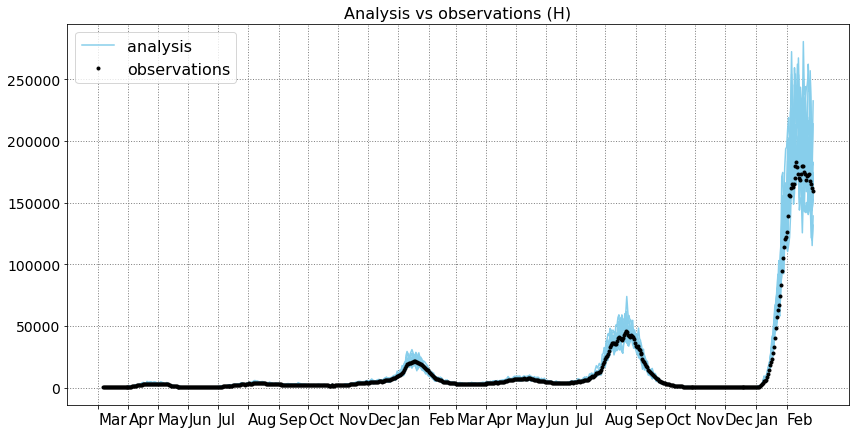

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14,7))
plt.plot([], color = 'orange',label = '1-day forecast')
plt.plot(np.exp(Xf_history[:,3,:]),color= 'orange')
plt.plot(np.exp(y_obs[:,0]), linestyle = 'None', marker = '.', color = 'k',label = 'observations')
#plt.xlim(500,580)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xticks([-5,26,56,87, 117, 148, 179, 209, 240, 270, 301, 332,360, 391,421, 452,482, 512, 543, 573,604,634,666,697], 
               ['Mar','Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec','Jan', 'Feb'],size = 15, ha = 'left')

plt.legend(loc = 'best',fontsize = 16)
plt.grid(color = 'grey', linestyle = ':', linewidth = 1)
plt.title('Forecast vs observations (H)',fontsize = 16)
plt.show()

plt.figure(figsize = (14,7))
plt.plot(np.exp(Xp_history[:,3,:]),color = 'skyblue')
plt.plot([], color = 'skyblue',label = 'analysis')
plt.plot(np.exp(y_obs[:,0]), linestyle = 'None', marker = '.', color = 'k',label = 'observations')
#plt.xlim(500,580)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.xticks([-5,26,56,87, 117, 148, 179, 209, 240, 270, 301, 332,360, 391,421, 452,482, 512, 543, 573,604,634,666,697], 
               ['Mar','Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec','Jan', 'Feb'],size = 15, ha = 'left')

plt.legend(loc = 'best',fontsize = 16)
plt.grid(color = 'grey', linestyle = ':', linewidth = 1)
plt.title('Analysis vs observations (H)',fontsize = 16)
plt.show()




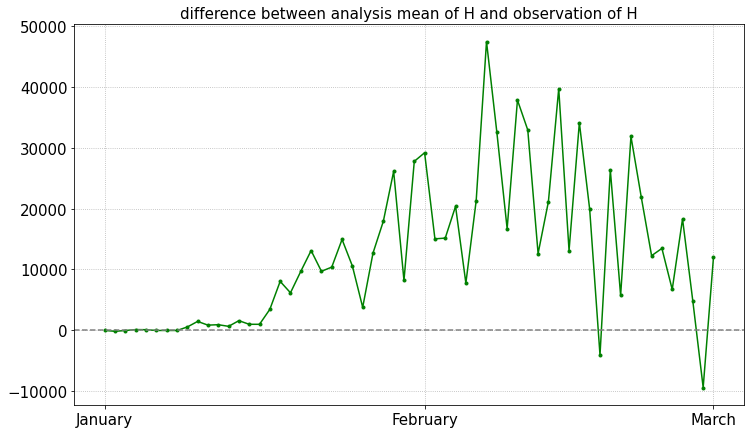

In [62]:
plt.figure(figsize = (12, 7))
#plt.legend(loc = 'best', fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(linestyle = ':')
plt.xticks([0, 31, 59], ['January', 'February', 'March'], fontsize = 15)
plt.plot(np.mean(np.exp(Xp_history[-60:,3,:]), axis = 1) - np.exp(y_obs[-60:,0]), marker = '.', color = 'green')
plt.title('difference between analysis mean of H and observation of H', fontsize =15)
plt.axhline(1, linestyle = 'dashed', color = 'grey')
plt.savefig('hdiff',bbox_inches = 'tight', dpi = 300)

In [4]:
 with open('hdiff.txt', 'rb') as f: 
        hdiff = pickle.load(f)
 with open('R_all.txt', 'rb') as f: 
        R_all = pickle.load(f)

In [5]:
hdiff = np.vstack()

(10, 60)

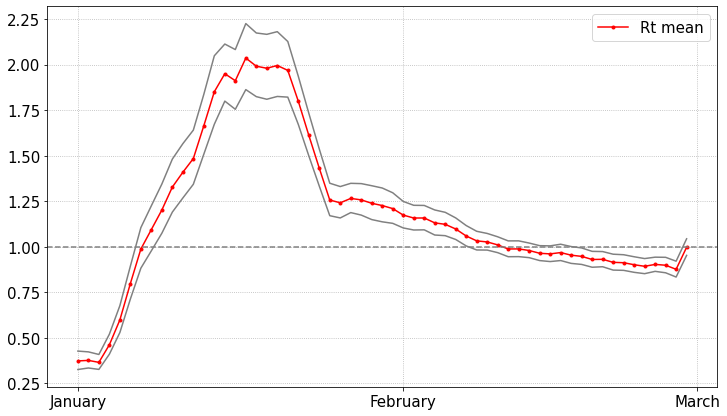

In [64]:
plt.figure(figsize = (12, 7))

plt.plot(RT_mean2, color  = 'red', marker = '.', label = 'Rt mean')
plt.plot(RT_conf[0,666:], color = 'grey')
plt.plot(RT_conf[1,666:], color = 'grey')
plt.legend(loc = 'best', fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(linestyle = ':')
plt.xticks([0, 31, 59], ['January', 'February', 'March'], fontsize = 15)
plt.axhline(1, linestyle = 'dashed', color = 'grey')
#plt.savefig('Rt_202201_202203',bbox_inches = 'tight', dpi = 300)

In [16]:
hdiff[9,:] = copy.copy(np.mean(np.exp(Xp_history[-60:,3,:]), axis = 1) - np.exp(y_obs[-60:,0]))
R_all[9,:] = copy.copy(RT_mean2)

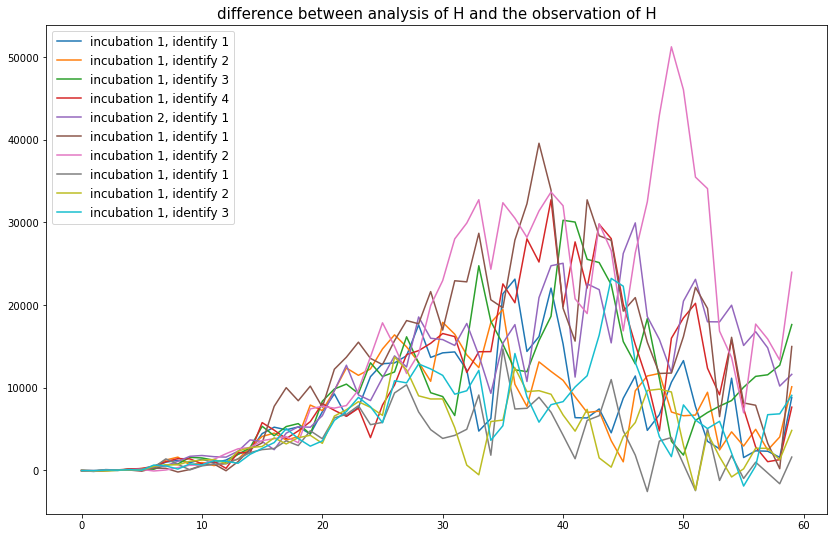

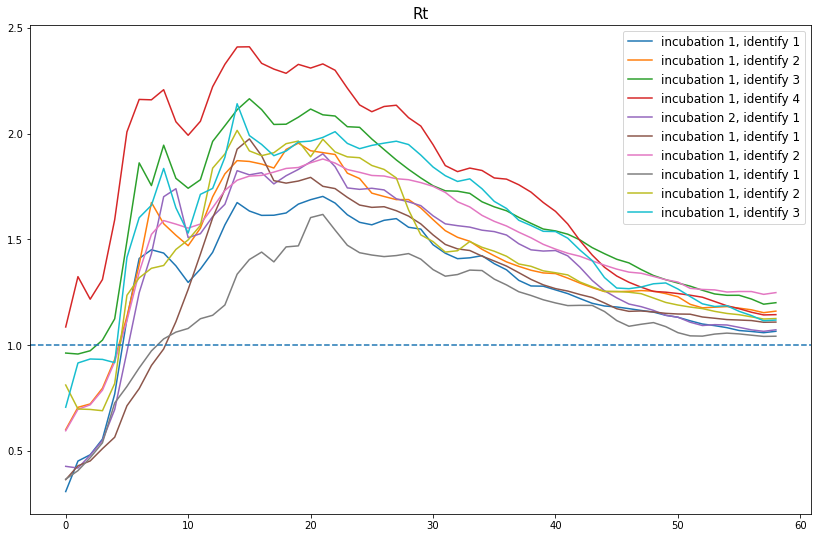

In [21]:
incubation = ['1','1','1','1','2','1','1','1','1','1']
identify = ['1', '2', '3','4','1', '1', '2', '1','2','3']
plt.figure(figsize = (14,9))
for i in range(10):
    plt.plot(hdiff[i], label = 'incubation %s, identify %s'%(incubation[i], identify[i]))
    plt.legend(loc = 'best', fontsize = 12)
plt.title('difference between analysis of H and the observation of H',fontsize = 15)
plt.savefig('diff_h', bbox_inches = 'tight', dpi = 300)
plt.show()

plt.figure(figsize = (14,9))
for i in range(10):
    plt.plot(R_all[i], label = 'incubation %s, identify %s'%(incubation[i], identify[i]))
    plt.legend(loc = 'best', fontsize = 12)
plt.axhline(1, linestyle = 'dashed')
plt.title('Rt',fontsize = 15)
plt.savefig('rt', bbox_inches = 'tight', dpi = 300)
plt.show()

In [22]:
with open('R_all.txt', 'wb') as f:
    pickle.dump(R_all, f)
with open('hdiff.txt', 'wb') as f:
    pickle.dump(hdiff, f)